<img src="../tree/Fig/Logo.jpg" alt="FLAMEGPU" width="600px"/> 

# Welcome to FLAMEGPU2 Tutorial

For the purpose of this tutorial, the Jupyter notebook has been configured to work with FLAMEGPU. The Jupyter notebook is a web based environment for interactive computing.  It is capable of running code in a wide variety of programming languages. Once the instance is up and running, you can simply click on the links, and start the tutorial in the web based environment. The notebook consists of cells which can be of type code or markdown (by default, new cells are created as *code* cells). If the content is code, it will be sent to the kernel for execution and output will be displayed in the footer of the cell. If the content is markdown, it will be rendered as HTML and serves as explanatory text. You can execute the content by clicking the **_Run_** button. 


Note: You can launch the terminal from the following link:
TODO: Update link
[FLAME GPU Tutorial Terminal for your instance](../terminals/FLAMETerminal)

or run commands using the exclamation mark. e.g. see below

In [ ]:
!echo "Hello World"

# Building FLAMEGPU2

A copy of starting code exists in your `Home` directory. Note: this is not the full FLAMEGPU2 version as all examples other than the predator prey model are omitted. The full version of FLAMEGPU can be downloaded from the [website](www.flamegpu.com).

A typical top-level directory layout is as below:


* __build:__ The location of the console and visualisation binaries for each of the examples. There is a Linux shell script for the example which will start the simulation with an initial states file (and the number of iterations to simulation in console mode)
* __iterations:__ Contains the initial state file
* __src:__ Contains main.cu, the main source file. This file includes the model definition and agent behaviours


Note: The FLAME GPU2 documentation and user guide is still under development, but can be found at [https://github.com/FLAMEGPU/FLAMEGPU2_userguide].

We are going to work with a predator-prey model. Navigate to the `ALifeTutorial` directory, create a build directory then use cmake and make to build FLAMEGPU2 and the predator-prey model. The first time this is done the compilation will take a few minutes as the whole library is built. Building individual models is much faster and will not require rebuilding the library. FLAMEGPU can be executed as either a console application or as an interactive visualisation. Binary files are placed in `build/bin/linux-x64/<OPT>`, where `<OPT>` is either `Release` or `Debug`. Today we will use the console release mode. Run the command cell below and then carry on reading through the document. We will introduce the predator-prey model while the library is building.

In [ ]:
%cd ~/ALifeTutorial/
!mkdir -p build
%cd build
!cmake .. 
!make -j8

# The Predator-Prey Model

## Model Description

Predator prey models capture the dynamic behaviours of competing species within an environment to demonstrate population dynamics as species try to survive. The model is important as it captures emergent macro level phenomenon which can be observed within other domains such as economics. 


In its most basic form, a two species system consists of both prey and predators. Prey reproduce but are eaten by predators and predators reproduce and eat prey.  Typically such systems can be represented using non linear differential equations known as Lotka-Volterra equations. In a more advanced form of the model, microscopic behaviours of the species can be considered by using agent based representation. E.g. The predators can have energy which is depleted as they move. Prey can form cohesive groups (flocking) and dynamically avoid predators, while predators can move towards prey. If a predator and prey are close enough (i.e. within a fixed kill radius), the predator is able to eat the prey and increase the amount of energy it has. Predators die when they run out of energy.

The model has been implemented in various Agent Based Modelling frameworks (e.g:NetLogo and FLAME). The tutorial model implements the following behaviours:

* Predator and Prey agents move and act in a sequence of iterations (time steps).
* Predator and Prey agents have real valued (x, y) positions and velocities which are integrated over time.
* Predator agents have an initial velocity. A Predator adjusts its velocity to follow the nearest prey within a synthetic limited vision.
* A predator’s energy is reduced by 1 unit of energy each time it moves.
* Prey are eaten by the closest predator agent within a fixed (kill) radius.
* A predator’s energy increases each time it catches a prey.
* A predator dies if it has run out of energy.

More specific details of the model features are described below.

__Prey catching__
There is no limit on the amount of prey a predator can eat per iteration. If a predator is close to multiple prey within the specific (kill) radius, the predator will kill/eat them all. A prey cannot be shared between multiple predators. If there are multiple predators within the kill radius then only the closest will eat the prey.

__Reproduction__
Each species has a rate of reproduction. When an agent reproduces, the parent’s energy is shared evenly between parent and child, so both will have half of the parent’s energy for the next iteration.

## FLAMEGPU2 Implementation

The FLAMEGPU implementation of the predator prey model is based on the assumptions made in the previous section. All agents have a real valued position (`x`,  `y`) within a continuous environment. The environment bounds are wrapped to form a continuous toroidal space in which agents can move. Agents have a velocity (`vx` and `vy`) in which they will move and a steering velocity (`steer_x` and `steer_y`) which dictates how they should adjust their velocity according to local interactions.Predator agents have a variable (`life`) which contains their level of energy. An agent variable `type` is used for visualisations of the simulation where unique type values correspond to different colours within the visualisation. The type is set by the initial values of the agent and does not change over time.

Each agent has a unique identifier variable (`id`). When a predator kills a prey, it is necessary to communicate identifiers to ensure correct behaviour as will be explained later in this section.

All communication between agents in FLAMEGPU2 is performed indirectly via messages. In this model we have three message types which are required to perform the mechanism for killing. E.g,

*  Both prey and predators output their (x, y) coordinates to a prey or predator location message respectively. 
*  Prey read predator locations and perform evasive behaviour to avoid them.
*  Predators read prey locations and move towards the closest visible prey.
*  Prey read each others location and move towards each other to form cohesive groups.
*  Both predators and prey read their own species' locations to avoid each other when in close proximity.
*  Prey read the locations of predators and calculate the nearest predator within the kill distance. If a predator is within the kill distance then it notifies this predator by sending a `prey_eaten_message` message with the predator's `id` and the eaten prey dies (is removed for the simulation).
*  Predators read the `prey_eaten_message` messages and check the to see if their `id` has been communicated by any dead prey. If the message indicates that the predator ate some prey, then the predator increases its energy/life accordingly.

## The FLAMEGPU Model
A FLAMEGPU model specification consists of: an __environment__ which holds global information related to the simulation such as constant variables and behaviour script file names, __agents__ which describe use variables and functions to describe the properties and behaviours of individuals in the simulation, and __messages__ which represent information communicated between agents. Each aspect is introduced in the following subsections with examples. If you are confident of the model's behaviour and the FLAMEGPU syntax then feel free to move onto the hands on material.

In FLAMEGPU2, all of these model elements are described in the `main.cu` file in the `src` folder. A `ModelDescription` object acts as a container for the various components which make up the model. The following sections will describe how to create each component and attach it to the `ModelDescription`. The `ModelDescription` is declared at the beginning of the `main` function:

```
    ModelDescription model("Tutorial_PredatorPrey_Example");
```

### FLAMEGPU environment

For the Predator-Prey model a number of self explanatory model parameters are described within the environment section. The first line of the code below queries the model to allow us to modify its environment through the `EnvironmentDescription` object, env. Environmental parameters can be added by name and type and are given a default value. These default values may be overwritten by an optional XML file describing the initial state of the simulation. This allows modification of model parameters without recompiling the code.

```
    EnvironmentDescription &env = model.Environment();
    env.add<float>("REPRODUCE_PREY_PROB", 0.05f);
    env.add<float>("REPRODUCE_PREDATOR_PROB", 0.03f);
    env.add<int>("GAIN_FROM_FOOD_PREDATOR", 50);
    env.add<int>("NUM_PREDATORS", 400);
    env.add<int>("NUM_PREY", 800);
```

### Agent memory

Agents represent individuals in the simulation and are defined using a `AgentDescription`. Much like the environment, we ask the model to provide us with a reference to the new agent which we can then add variables to. As with the environment, each variable is given a type and a name. The variables do not have default values, these variables are instead set per agent before the simulation starts. The description of the prey agent's memory/properties in FLAMEGPU2 is given below:

```
    AgentDescription &agent = model.newAgent("prey");
    agent.newVariable<int>("id");
    agent.newVariable<float>("x");
    agent.newVariable<float>("y");
    agent.newVariable<float>("vx");
    agent.newVariable<float>("vy");
    agent.newVariable<float>("steer_x");
    agent.newVariable<float>("steer_y");
    agent.newVariable<int>("life");
    agent.newVariable<float>("type")
```

### Agent functions

Agent functions are used to implement agent behaviours. The tables below give the functions of the predators and prey and their roles.

| Function             | Description                                                    |
|:---------------------|:---------------------------------------------------------------|
| prey_output_location | each prey agent outputs information to be read by other agents |
| prey_avoid_pred      | prey agents avoiding predator agents                           |
| prey_flock           | flocking between prey agents                                   |
| prey_move            | movement of prey agents                                        |
| prey_eaten           | prey agents get killed by predator agents                      |
| prey_reproduction    | regeneration of prey                                           |


| Function             | Description                                                        |
|:---------------------|:-------------------------------------------------------------------|
| pred_output_location | each predator agent outputs information to be read by other agents |
| pred_follow_prey     | predator agents follow prey agents                                 |
| pred_avoid           | predator agents avoid each other                                   |
| pred_move            | movement of predator agents                                        |
| pred_eat_or_starve   | predator agents gain energy or starve                              |
| prey_reproduction    | regeneration of predators                                          |



Functions can be applied to agents in a specified initial\_state and can optionally cause agents to move to other states. As our model is relatively simple, we only use a single default state. Furthermore, functions can have conditions. For example, a function which simulates agent death might check a variable incremented each iteration called life-cycles to see if it has reached a maximum number. Only agents meeting this condition would perform the behaviour and move into a dead state.  The predator-prey model is a stateless model (each agent has only a single state) as functions do not require any function conditions. The dependencies and order of functions is described within the models function layers which dictate the ordering of execution.

Functions can have either a single input or output (or neither). Inputs and outputs are in the form of messages which are a collection of variables which are persistent from the point in which they are output to the end of the simulation iteration (at which point they are destroyed). A function description within a model requires that any inputs or outputs are fully specified. 

Creating functions in FLAMEGPU2 is a two-stage process. First, we declare that a function exists and define its inputs, outputs and properties, much like the other components of the model:

```
    agent.newFunction("pred_output_location", pred_output_location).setMessageOutput("predator_location_message");
```

For simple functions such as the one above, we can use `.setMessageOutput` or `.setMessageInput` to set a single property as the function is created. For more complex functions with multiple properties, we can make use of `newFunction` returning a reference to our newly-created function. The code below shows the declaration of a function called `prey_eaten` which has `predator_location_message` as input, `prey_eaten_message` as output, may or may not output a message and can result in the agent dying.

```
    auto& function = agent.newFunction("prey_eaten", prey_eaten);
    function.setMessageInput("predator_location_message");
    function.setMessageOutput("prey_eaten_message");
    function.setMessageOutputOptional(true);
    function.setAllowAgentDeath(true);
```

With the knowledge of how to declare functions, we can now see how one is implemented in the function body:

```
    FLAMEGPU_AGENT_FUNCTION(prey_eaten, MsgBruteForce, MsgBruteForce) {
        int eaten = 0;
        int predator_id = -1;
        float closest_pred = PRED_KILL_DISTANCE;
        const float prey_x = FLAMEGPU->getVariable<float>("x");
        const float prey_y = FLAMEGPU->getVariable<float>("y");
        
        // Iterate predator_location messages to find the closest predator
        for (const auto& msg : FLAMEGPU->message_in) {
            // Fetch location of predator
            const float predator_x = msg.getVariable<float>("x");
            const float predator_y = msg.getVariable<float>("y");
        
            // Check if the two predators are within interaction radius
            const float dx = prey_x - predator_x;
            const float dy = prey_y - predator_y;
            const float distance = sqrt(dx*dx + dy*dy);
        
            if (distance < closest_pred) {
                predator_id = msg.getVariable<int>("id");
                closest_pred= distance;
                eaten = 1;
            }
        }
        
        if (eaten) {
            FLAMEGPU->message_out.setVariable<int>("id", FLAMEGPU->getVariable<int>("id"));
            FLAMEGPU->message_out.setVariable<int>("pred_id", predator_id);
        }
    
        return eaten ? DEAD : ALIVE;
    }
```

We can see in the above function how to use local variables, get agent variables using `FLAMEGPU->getVariable`, iterate over the input messages and set message outputs. Finally, we also see that either `DEAD` or `ALIVE` can be returned to signify whether the agent should be removed from the simulation or not. Not shown here is the `FLAMEGPU->setVariable<type>(variableName, value)` function which is used to set agent variables.

The final piece of the puzzle is __function layers__ which define the order functions should be executed in. Functions in the same layer may be executed concurrently. Some of the function layers from this model are shown below:

```
    {   // Layer #1
        LayerDescription &layer = model.newLayer();
        layer.addAgentFunction(prey_output_location);
        layer.addAgentFunction(pred_output_location);
        layer.addAgentFunction(grass_output_location);
    }
    {   // Layer #2
        LayerDescription &layer = model.newLayer();
        layer.addAgentFunction(pred_follow_prey);
        layer.addAgentFunction(prey_avoid_pred);
    }
    {   // Layer #3
        LayerDescription &layer = model.newLayer();
        layer.addAgentFunction(prey_flock);
        layer.addAgentFunction(pred_avoid);
    }
```

### Agent messages

Messages are defined as simple collections of variables which are used to communicate data between agents. Messages are defined in the same way as the environment variables and agents, however, messages also require a choice of spatial partitioning scheme. These schemes are typically used to improve computation time by limiting the messages each agent sees to those which are nearby. Spatial partitioning is simple to use in FLAMEGPU2, although we will use the simplest messaging type, `MsgBruteForce` which features no partitioning. This indicates that the message reading functions will iterate all messages in the list. The code below shows the definition of a brute force message which can be used to communicate the location of a prey agent:

```
    MsgBruteForce::Description &message = model.newMessage("prey_location_message");
    message.newVariable<int>("id");
    message.newVariable<float>("x");
    message.newVariable<float>("y");
```

The diagram below shows the structure of the model, including the agents, their functions and the messages used to communicate.

<img src="../tree/Fig/prey_pred.png" alt="Flow diagram for Predator-Prey model" width="600px"/> 

## Input data generation and Setup

The initial agent data for the model can either be specified within the `main.cu` file or in an XML file. In this tutorial, we demonstrate the agents being generated programmatically in `main.cu`. The program generates the specified number of predator and prey agents in random positions (`x,y`) between [-1,1] with random velocities (`vx,vy`) between [-1,1]. Each predator is given an amount of energy (`life`) which is randomly selected from the interval of [0,40]. Prey are initialised with random positions between [-1, 1], a velocity of 0 and energy randomly selected in the interval [0, 50]. The following code shows the generation of the prey agents, where floatDist and preyLifeDist generate random numbers in the intervals [-1, 1] and [0, 50] respectively:

```
    AgentPopulation preyPopulation(model.Agent("prey"), numPrey);
    for (int i = 0; i < numPrey; i++) {
        AgentInstance prey = preyPopulation.getNextInstance();
        prey.setVariable<int>("id", i);
        prey.setVariable<float>("x", floatDist(gen));
        prey.setVariable<float>("y", floatDist(gen));
        prey.setVariable<float>("vx", floatDist(gen));
        prey.setVariable<float>("vy", floatDist(gen));
        prey.setVariable<float>("steer_x", 0.0f);
        prey.setVariable<float>("steer_y", 0.0f);
        prey.setVariable<float>("type", 1.0f);
        prey.setVariable<int>("life", preyLifeDist(gen));
    }
```


As we wish to have specific environmental parameters which we can easily updated, these are loaded from the `0.xml` initial states file. A python script which automatically generates the XML file will be used in this tutorial. The default `0.xml` file has been generated using the following parameters:

* __Initial number of prey agents__ 800
* __Initial number of predator agents__ 400
* __Amount of energy gained from eating prey__ 75
* __Probability of predators reproducing:__ 0.03
* __Probability of prey reproducing:__ 0.05

# Running a model with FLAMEGPU2

The project we just built already includes the source for our starting implementation of the predatory-prey model, so this was built along with the library. To run the executable, call it with the following command:

In [ ]:
%cd  ~/ALifeTutorial/
!./build/bin/linux-x64/Release/flamegpu2_example -i iterations/0.xml -s 1

An example output would look like below:

```
/home/matt/ALifeTutorial
XML file 'iterations/0.xml' loaded.
Model initialised, beginning simulation...
Data saved
Simulation complete

```

Examine the run script by looking at the parameters passed to the simulation. The parameters are the initial model file (-i) and the number of iterations (-s)). 

In order to modify the number of iterations, simply modify the iteration number (-s). Let's navigate to where the binary file is located and run the binary file as follows:

In [ ]:
%cd  ~/ALifeTutorial/
!./build/bin/linux-x64/Release/flamegpu2_example -i iterations/0.xml -s 10

The output will be a *csv* file `iterations\PreyPred_Count.csv` which will have logged the population counts for the initial state and for the simulation step. 


When executing the binary file, you can use the following input arguments:

* `-i, --in <file.xml>` : Use <file.xml> to define the initial state
* `-s, --steps <steps>` : Run the simulation for <steps> iterations
* `-r, --random <seed>` : Use <seed> as the seed for the RandomManager
* `-v, --verbose` : Enable verbose FLAMEGPU output
* `-t, --timing` : Output timing information to stdout
* `-d, --device` : Specify the index of the GPU which should be used
    

# Exercise 01: Building FLAME GPU in notebook

In exercise one, we are going to build and execute the simulation program for the basic Predator-Prey model, followed by plotting the output results. Navigate to the `ALifeTutorial/build` directory and run `make`.

In [1]:
%cd ~/ALifeTutorial/build
!make -j8

/home/matt/ALifeTutorial/build
[  3%] Built target tinyxml2
[ 94%] Built target flamegpu2
Scanning dependencies of target flamegpu2_example
[ 96%] Building CUDA object CMakeFiles/flamegpu2_example.dir/src/main.cu.o
/home/matt/ALifeTutorial/build/_deps/thrust-src/cub/block/specializations/../../block/block_exchange.cuh(716): warning #1719-D: the initialization of member "cub::BlockExchange<InputT, BLOCK_DIM_X, ITEMS_PER_THREAD, WARP_TIME_SLICING, BLOCK_DIM_Y, BLOCK_DIM_Z, PTX_ARCH>::lane_id" will be done before that of member "cub::BlockExchange<InputT, BLOCK_DIM_X, ITEMS_PER_THREAD, WARP_TIME_SLICING, BLOCK_DIM_Y, BLOCK_DIM_Z, PTX_ARCH>::warp_id"

/home/matt/ALifeTutorial/build/_deps/thrust-src/cub/device/dispatch/../../agent/agent_histogram.cuh(709): warning #1719-D: the initialization of member "cub::AgentHistogram<AgentHistogramPolicyT, PRIVATIZED_SMEM_BINS, NUM_CHANNELS, NUM_ACTIVE_CHANNELS, SampleIteratorT, CounterT, PrivatizedDecodeOpT, OutputDecodeOpT, OffsetT, PTX_ARCH>::output

## Running the model

Now, run the simulation for 100 iterations:

In [16]:
%cd  ~/ALifeTutorial/
!./build/bin/linux-x64/Release/flamegpu2_example -i iterations/0.xml -s 100

/home/matt/ALifeTutorial
XML file 'iterations/0.xml' loaded.
Model initialised, beginning simulation...
Data saved
Simulation complete


## Generate and view the graph

The generated *csv* file contains the number of prey and predator agents per iteration. Navigate to the `iterations` folder and plot the result:

/home/matt/ALifeTutorial/iterations


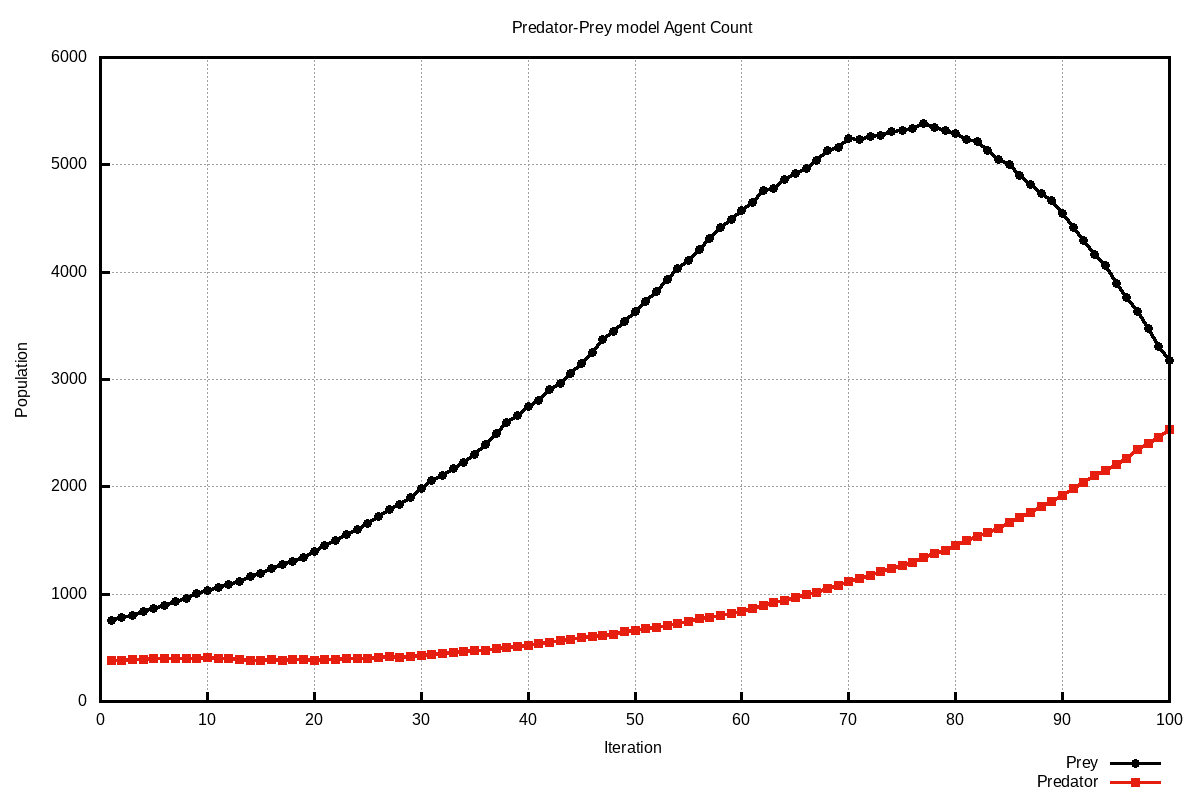

In [17]:
%cd ~/ALifeTutorial/iterations
!gnuplot make_plot_PreyPred.gp 2&>/dev/null
from IPython.display import Image
Image("PreyPredator.png")

   # Exercise 02: Changing Predator-Prey model's behaviour

Now, let's change the parameters in the initial data and see how it affects the behaviour. To generate a new randomised set of initial data `0.xml`, navigate to the iterations folder and use the python script 'xmlGen.py'. 

1. Compile and re-run the executable with different parameters:


In [15]:
%cd ~/ALifeTutorial/iterations
!python3 xmlGen.py 800 400 0.05 0.03 50

/home/matt/ALifeTutorial/iterations
XML file generated successfully!



where 800 is the number of prey, 400 is the number of predators, 0.05 and 0.03 are the reproduction rates for the prey/predators respectively, and 50 is the energy a predator gains when eating a prey. 

2. Re-run the executable again for 300 iterations and plot the results. You can observe the predator prey behaviour where both species become extinct after certain number of iterations.

In [ ]:
%cd  ~/ALifeTutorial/
!./build/bin/linux-x64/Release/flamegpu2_example -i iterations/0.xml -s 300

Navigate to the `iterations` folder and plot the result: 

In [ ]:
%cd ~/ALifeTutorial/iterations
!gnuplot make_plot_PreyPred.gp 2&>/dev/null
from IPython.display import Image
Image("PreyPredator.png")

3. Change other parameters or the iteration number to see how the behaviour changes over time. Try to modify the simulation parameters to produce oscillating population dynamics.

   # Exercise 03: Extending the Predator-Prey model (Optional)
In this exercise, we are going to extend our model to include grass to familiarise you with how agents and their behaviours are implemented within FLAMEGPU2. The grass will provide a source of food for the prey which should behave according to the following rules:


* A prey’s energy is reduced by 1 unit each time it moves.
* A prey’s energy increases each time it eats grass.
* A prey dies if it has run out of energy.
* Once eaten, grass regrows after a fixed number of iterations.


With respect to the implementation this will require , a fourth and fifth message type as grass should only be eaten by prey within a certain certain radius. The mechanism for "grazing" is as follows:


1.  Grass agents which currently are currently available read the positions of the prey from the location messages to locate the nearest prey. 
2. If a prey was in eating range, a `grass_eaten_message` message is output. Note that if there is more than 1 prey on within the minimum distance, the grass agent should be eaten by the closest prey.
3.  Grass agents then modify the `active` agent variable to indicate they are in a regrowth period and cannot be eaten at this time.
4.  Prey agents read the `grass_eaten_message` messages and check to see if any match their ID. They then increase their energy accordingly.
5. Prey agents die if they do not have enough life/energy.



The figure below shows a dependency graph for the Predator-Prey model with grass: 

<img src="../tree/Fig/prey_pred_grass.jpg" alt="Flow diagram for Predator-Prey model with grass" width="600px"/> 


For simplicity a Grass agent description and corresponding function descriptions matching the behaviour described above have already been added to `src/main.cu`. In this exercise, you need to modify the `main.cu` file to add the following behaviour to the functions stubs described below (See [Last Section](#Editing-Files) on how to edit source files):

* 3.1 *__grass_output_location__*: each grass agent outputs a `grass_location` message to provide information. In a more advanced model prey agent can use this information to migrate to areas of high food concentration.
* 3.2 *__grass_eaten__*: each grass agent should iterate over `prey_location_messages` and checks the distance between its location and the prey agent. If the grass is available and the distances less than `GRASS_EAT_DISTANCE`, then the grass is eaten by the closet prey and the regrowth cycle starts. Note that if there are multiple preys within the `GRASS_EAT_DISTANCE`, then the closet prey to the grass, eats it and outputs a message `grass_eaten` containing the ID of the prey who ate it. This behaviour is very similar to prey checking if they are eaten by predators, you may wish to look at the `prey_eaten` function for inspiration. Once the grass is eaten, it should no longer be available until the `death_cycles` reaches `GRASS_REGROW_CYCLES`. 
* 3.3 *__prey_eat_or_starve__*: each prey agent iterates over `grass_eaten_messages` and checks the ID against it ID. If the grass eaten message indicates that this prey ate some grass then increase the prey's life by adding energy. If it's life is less than 1, the prey should die. This behaviour is similar to the `pred_eat_or_starve` function.
* 3.4 *__grass_growth__*: If the the `death_cycles` variable is equal to `GRASS_REGROW_CYCLES`, then the grass agent becomes available and the `death_cycles` should restart. If the grass is not available (meaning the `death_cycles` variable is not equal to `GRASS_REGROW_CYCLES`), then the `death_cycles` variable should be incremented.

The function stubs include comments stating which exercise they are for, so you can search for 3.1 to find the correct function body for exercise 3.1 etc.

In the case where grass is included, prey agents require an energy (`life`) variable similar to predators. This variable is randomly selected from the interval of [0,50]. Once grass is eaten, the `available` variable is set to 0 and it takes up to `GRASS_REGROW_CYCLES` iterations till the grass re-grow. 

Various values have been defined using `#define` at the top of the `main.cu` file for you which will produce sensible results with a correct implementation of the above behaviours. These can be used directly in your code, e.g. `if(death_cycles == GRASS_REGROW_CYCLES)`. A list of the new parameters is given below:

__GRASS_REGROW_CYCLES__: The number of iterations it takes grass to regrow and become available again
__GRASS_EAT_DISTANCE__: The range within which prey can eat grass
__GAIN_FROM_FOOD_PRE__: The energy gained by a prey agent upon eating a grass agent

Now, generate a new initial data file using below parameters:

In [ ]:
%cd ~/ALifeTutorial/iterations
!python3 xmlGenWithGrass.py 800 400 2000 0.05 0.03 50

where 800 is the number of prey, 400 is the number of predators, 2000 is the number of grass, 0.05 and 0.03 are the reproduction rates for both prey and predator and 50 is the predator's energy gain. 


Re-build the model via `make`:

In [ ]:
%cd ~/ALifeTutorial/build
!make -j8

Now, run the simulation for 600 iterations:

In [ ]:
%cd  ~/ALifeTutorial/
!./build/bin/linux-x64/Release/flamegpu2_example -i iterations/0.xml -s 600

Now, plot your results by running below cell. Your plot should be similar to below figure:

<img src="../tree/Fig/prey_predator_grass.jpg" alt="Examples of predator-prey model simulation with grass included" width="600px"/> 

In [ ]:
%cd ~/ALifeTutorial/iterations
!gnuplot make_plot_PreyPred_IncGrass.gp 2&>/dev/null
from IPython.display import Image
Image("PreyPredator.png")

## Experimenting with the Model
Try changing the parameters to see how this will change the behaviour of the agents causing the behaviours to change. In addition to using the script to modify initial prey populations, you can also edit the grass variables by changing the relevant numbers in the `#define` section at the top of `main.cu`. If you have completed all the above exercises then try modifying the model file and functions file to allow prey agents to migrate to areas of high concentrations of food. You can implement this by adding an additional velocity term to the preys steering velocity and by allowing the prey agents to query the `grass_location` messages.

For more information on FLAMEGPU see the [FLAMEGPU website](http://www.flamegpu.com) and the documentation which gives detailed instructions on all aspects of FLAMEGPU modelling. More examples can be found on [FLAMEGPU2 GitHub repository](https://github.com/FLAMEGPU/FLAMEGPU2_dev.git), but do remember version 2 is still under heavy development.

You can download the solutions from GitHub by checking out the `Exercise_3_solution` branch. E.g. 

In [ ]:
!git clone https://github.com/MILeach/ALifeTutorial -b Exercise_3_solution

# Editing Files

You can use Jupyter to edit model files. Use this link to explore the [turorial directory](../tree) or use below links to open the model file, functions file or initial model data directory for editing:

* [main.cu](../edit/src/main.cu)
* [0.xml](../edit/iterations/0.xml)

Note: You are given 3, 2-hour sessions for this tutorial. Save and download your modifed files before the end of each session.
